In [1]:
import pickle
import os
import sys
import pandas as pd
import yfinance as yf
import numpy as np
sys.path.append(os.path.join('ML_additoinal_files'))

from config import *
from helper import *
from model import *

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import warnings

import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
import matplotlib.pyplot as plt
from time import time


warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
pd.options.mode.chained_assignment = None 

In [2]:
price_data_df = collecting_data(START_DATE, END_DATE, DATA_OPEN_LOC, DATA_CLOSE_LOC, DATA_HIGH_LOC, DATA_LOW_LOC, DATA_VOL_LOC, DATA_DIV_LOC)
relative_df = get_relative(price_data_df)
risk_free_rate_list = get_risk_free_rate(START_DATE, END_DATE)
risk_free_rate = float(risk_free_rate_list.mean())
open_positions = momentum_strategy_stat(price_data_df, relative_df)

[*********************100%***********************]  1 of 1 completed


In [3]:
features_dict = calc_variability_per_stocks(price_data_df, open_positions, risk_free_rate, GROUP_LABELS)

Stocks marked as Winners
Winners Data
Train length: (6383, 23), Test length: (2736, 23)


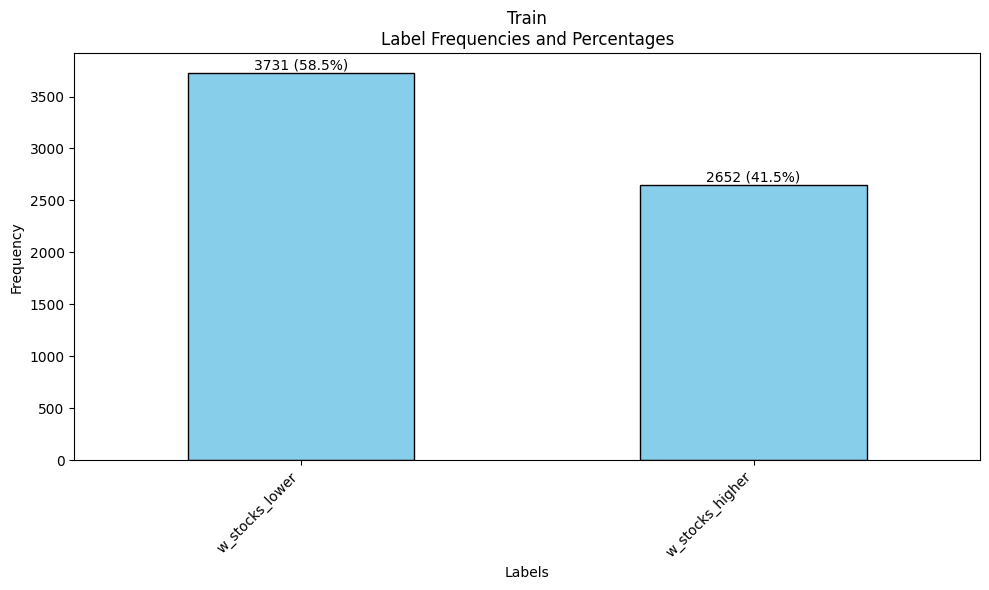

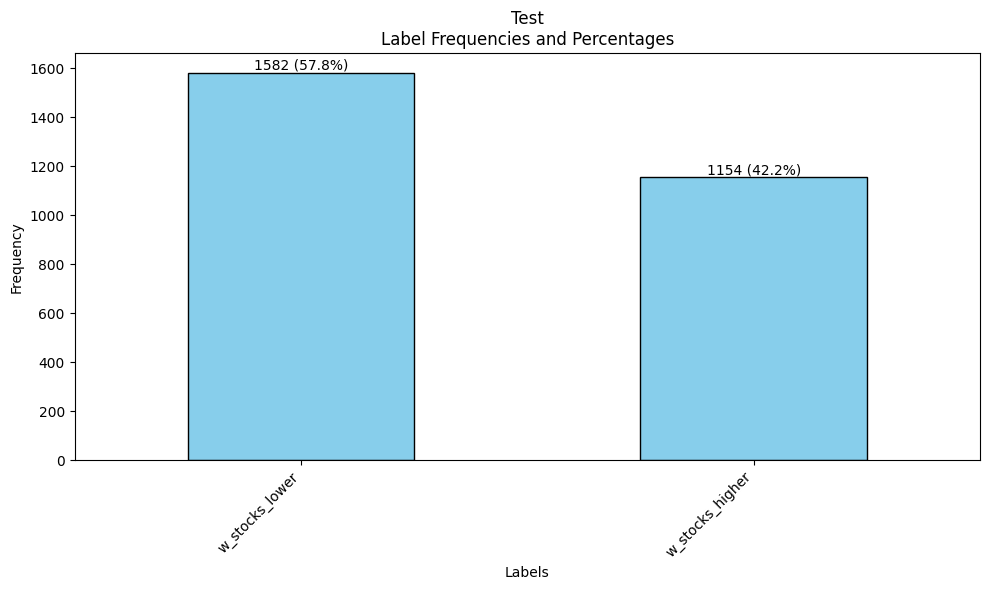

In [4]:
df = pd.DataFrame(features_dict).T
df = df[~df.isin([float('inf'), float('-inf')]).any(axis=1)]

print('Stocks marked as Winners')
df_w = df[df['label'].isin([GROUP_LABELS['w_stocks_higher'],GROUP_LABELS['w_stocks_lower']])]
train_range = int(len(df_w) * TRAIN_SPLIT)
w_train_df, w_test_df = split_train_test(df_w, train_range, 'Winners')

Stocks marked as losers
Losers Data
Train length: (6383, 23), Test length: (2736, 23)


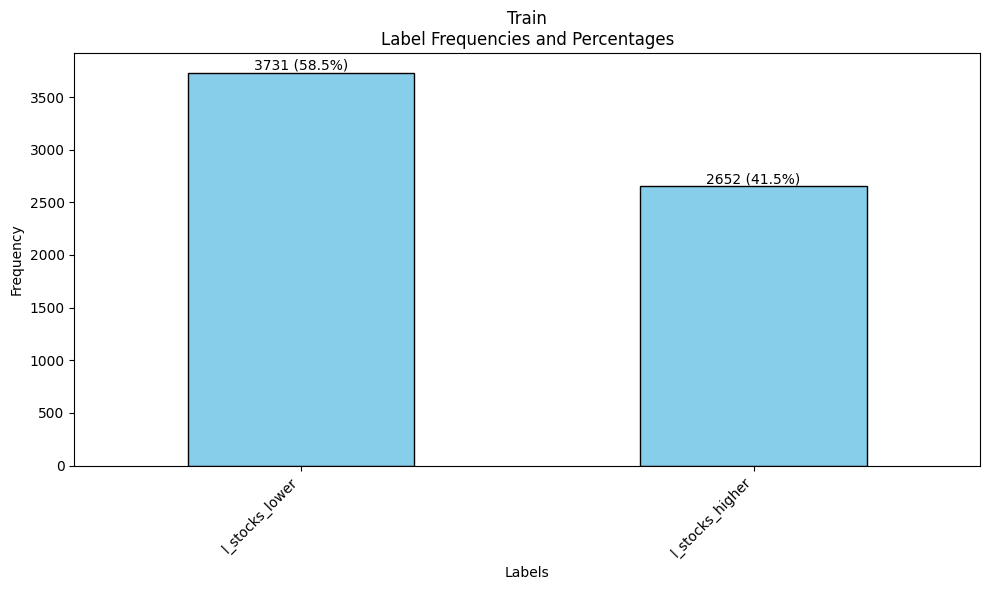

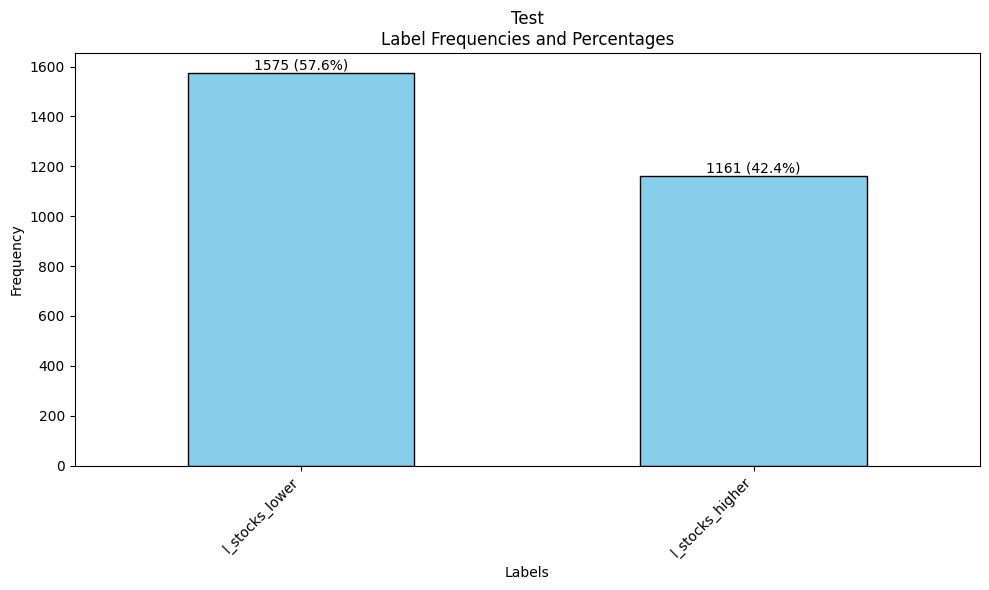

In [5]:
print('Stocks marked as losers')
df_l = df[df['label'].isin([GROUP_LABELS['l_stocks_higher'],GROUP_LABELS['l_stocks_lower']])]
train_range = int(len(df_l) * TRAIN_SPLIT)
l_train_df, l_test_df = split_train_test(df_l, train_range, 'Losers')

In [6]:
# pipeline = Pipeline(steps=[('classifier', AdaBoostClassifier())])

# # Bootstrap aggregating
# RandomForestClassifier_param = {'classifier': [RandomForestClassifier()],
#                                 'classifier__n_estimators': [100,200],
#                                 'classifier__max_depth': [5, 10],
#                                 'classifier__class_weight': ['balanced'],
#                                 'classifier__min_samples_split': [2],
#                                 'classifier__random_state': [RANDOM_STATE]}
# RandomForestClassifier_param = {'classifier': [RandomForestClassifier()],
#                                 'classifier__n_estimators': [2,200],
#                                 'classifier__max_depth': [5],
#                                 'classifier__class_weight': ['balanced'],
#                                 'classifier__min_samples_split': [10],
#                                 'classifier__random_state': [RANDOM_STATE]}

# # # Boosting
# # AdaBoost_param = {'classifier': [AdaBoostClassifier()],
# #                   'classifier__n_estimators': [100, 200],
# #                   'classifier__learning_rate': [0.1, 1],
# #                   'classifier__random_state': [RANDOM_STATE]}

# GBClassifier_param = {'classifier': [GradientBoostingClassifier()],
#                       'classifier__n_estimators': [100, 200],    
#                       'classifier__max_depth': [3],
#                       'classifier__subsample': [0.1, 1.0],
#                       'classifier__learning_rate': [1],
#                       'classifier__random_state': [RANDOM_STATE]}

# params = [RandomForestClassifier_param]#, GBClassifier_param]#, XGBClassifier_param]

# def train_model(train_df):

#     gs = GridSearchCV(pipeline, param_grid=params, refit='f1_weighted', return_train_score=True, cv=10, n_jobs=-1, scoring='f1_weighted')
    
#     tic = time()
#     exclude_columns = ['date', 'label_name','stock']
#     clean_train_df = train_df.loc[:, ~train_df.columns.isin(exclude_columns)]
    
#     X = clean_train_df.drop(columns=['label'])
#     y =  pd.to_numeric(clean_train_df['label'])
    
#     print('train_df:',X.shape)
#     gs.fit(X, y)
#     toc = time()
#     print(f'GridSearchCV time(mintues): {round((toc-tic)/60,2)}')
     
#     return pd.DataFrame(gs.cv_results_), gs.best_estimator_, gs.best_estimator_[0].feature_importances_

In [7]:
w_cv_stat_df, w_model, w_f_importance = train_model(w_train_df)
l_cv_stat_df, l_model, l_f_importance = train_model(l_train_df)

train_df: (6383, 20)
GridSearchCV time(mintues): 5.22
train_df: (6383, 20)
GridSearchCV time(mintues): 5.21


# Evalute the model

In [8]:
w_cv_stat_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,param_classifier__class_weight,param_classifier__max_depth,param_classifier__min_samples_split,param_classifier__n_estimators,param_classifier__random_state,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,1.349034,0.113097,0.010242,0.000778,RandomForestClassifier(),balanced,5,2.0,100,42,...,0.657359,0.676420,0.678392,0.677084,0.690263,0.680634,0.687862,0.680348,0.679581,0.008559
1,2.494200,0.061359,0.016701,0.002902,RandomForestClassifier(),balanced,5,2.0,200,42,...,0.654607,0.674415,0.683389,0.680518,0.692150,0.686688,0.684447,0.680252,0.679358,0.009582
2,2.268923,0.251925,0.012854,0.001096,RandomForestClassifier(),balanced,10,2.0,100,42,...,0.838420,0.869010,0.875463,0.880498,0.896147,0.880601,0.867317,0.888744,0.874357,0.014713
3,4.404987,0.105988,0.022031,0.001423,RandomForestClassifier(),balanced,10,2.0,200,42,...,0.846011,0.872475,0.882430,0.885975,0.899290,0.886194,0.872558,0.891011,0.879406,0.013784
4,0.605352,0.016872,0.005405,0.001969,GradientBoostingClassifier(),NaN,3,NaN,100,42,...,0.537955,0.398070,0.457243,0.524960,0.312676,0.466169,0.401382,0.518325,0.460106,0.067302
5,5.632078,0.603896,0.005935,0.004595,GradientBoostingClassifier(),NaN,3,NaN,100,42,...,0.886499,0.880574,0.878640,0.869556,0.879220,0.882364,0.878120,0.881573,0.880972,0.005171
6,1.228275,0.024604,0.006199,0.001009,GradientBoostingClassifier(),NaN,3,NaN,200,42,...,0.537955,0.398070,0.457243,0.524960,0.312676,0.466169,0.401382,0.518325,0.460106,0.067302
7,12.304146,1.161478,0.005922,0.001487,GradientBoostingClassifier(),NaN,3,NaN,200,42,...,0.976100,0.970003,0.976827,0.967723,0.969149,0.971404,0.972452,0.969650,0.972152,0.002932


In [9]:
l_cv_stat_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,param_classifier__class_weight,param_classifier__max_depth,param_classifier__min_samples_split,param_classifier__n_estimators,param_classifier__random_state,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,1.472331,0.206702,0.010327,0.001506,RandomForestClassifier(),balanced,5,2.0,100,42,...,0.668092,0.635412,0.648634,0.647119,0.644950,0.649753,0.647935,0.653924,0.649649,0.007874
1,2.801406,0.406221,0.016272,0.001755,RandomForestClassifier(),balanced,5,2.0,200,42,...,0.669685,0.634248,0.646475,0.637165,0.640675,0.648636,0.648259,0.655958,0.648604,0.009742
2,2.332341,0.060639,0.013875,0.002824,RandomForestClassifier(),balanced,10,2.0,100,42,...,0.880985,0.789952,0.836334,0.821582,0.841695,0.827785,0.853454,0.841357,0.836902,0.021985
3,4.706183,0.142230,0.022496,0.003470,RandomForestClassifier(),balanced,10,2.0,200,42,...,0.880670,0.790385,0.835267,0.827793,0.833689,0.826679,0.856207,0.842544,0.837305,0.021892
4,0.808756,0.181160,0.006391,0.002522,GradientBoostingClassifier(),NaN,3,NaN,100,42,...,0.523003,0.377412,0.507635,0.530063,0.516978,0.458753,0.411645,0.478443,0.474379,0.051006
5,5.584601,0.291365,0.004546,0.000275,GradientBoostingClassifier(),NaN,3,NaN,100,42,...,0.878038,0.875960,0.875380,0.874609,0.874479,0.876545,0.879921,0.882939,0.878426,0.003687
6,1.310858,0.082411,0.005887,0.000511,GradientBoostingClassifier(),NaN,3,NaN,200,42,...,0.523003,0.377412,0.507635,0.530063,0.516978,0.458753,0.411645,0.478443,0.474379,0.051006
7,11.619005,1.304905,0.005338,0.000486,GradientBoostingClassifier(),NaN,3,NaN,200,42,...,0.972971,0.972810,0.968816,0.969852,0.976116,0.966193,0.972812,0.973686,0.972149,0.002815


In [11]:
from sklearn.metrics import recall_score, precision_score, f1_score

def measures_results(model, test_df):
    exclude_columns = ['date', 'label_name','stock', 'label']
    clean_test_df = test_df.loc[:, ~test_df.columns.isin(exclude_columns)]
    
    test_df['prediction'] = model.predict(clean_test_df)
    test_df['label'] = test_df['label'].astype(int)
    test_df['prediction'] = test_df['prediction'].astype(int)  
    
    r_score = recall_score(test_df['prediction'], test_df['label'] , average = 'weighted')
    p_score = precision_score(test_df['prediction'], test_df['label'] , average = 'weighted')
    f1 = f1_score(test_df['prediction'].values, test_df['label'].values, average='weighted')

    print(f'Precision: {p_score}\nRecall: {f1}\nf1_score: {f1}\n')

In [15]:
print('Winners')
measures_results(w_model, w_test_df)

print('Losers')
measures_results(l_model, l_test_df)

Winners
Precision: 0.5533329974399454
Recall: 0.549142883904195
f1_score: 0.549142883904195

Losers
Precision: 0.5869545634111117
Recall: 0.5547815311359601
f1_score: 0.5547815311359601



Winners


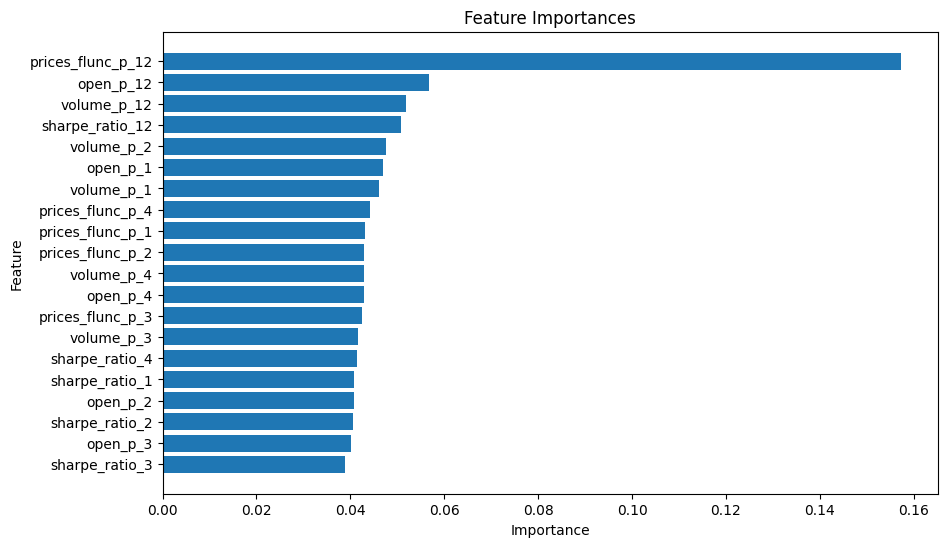

Losers


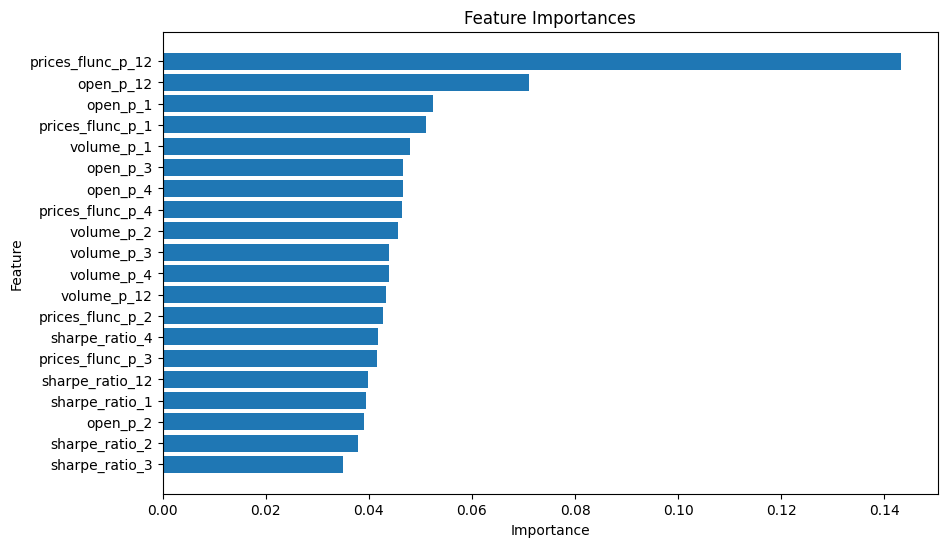

In [16]:
print_feature_importance(df, w_f_importance, 'Winners')
print_feature_importance(df, l_f_importance, 'Losers')

In [5]:
def single_stock_calc(date, features_dict, block, stock, group_labels, add_info_name, risk_free_rate):
    
    annual_return = ((block['Open'][stock].iloc[-1] + block['Dividends'][stock].sum(axis=0) - block['Open'][stock].iloc[0]) / block['Open'][stock].iloc[0]) - 1
    volatility = np.std(block['Open'][stock])
    sharpe_ratio = float((annual_return - risk_free_rate) / volatility)
    prices_flunc_p = float(np.std(block['Close'][stock] - block['Open'][stock]) / np.mean(block['Close'][stock] - block['Open'][stock]))
    volatility_p = float(np.std(block['Open'][stock]) / np.mean(block['Open'][stock]))
    volume_p = float(np.std(block['Volume'][stock]) / np.mean(block['Volume'][stock]))

    if len(features_dict):
        features_dict[f'sharpe_ratio_{add_info_name}'] = sharpe_ratio
        features_dict[f'open_p_{add_info_name}'] =volatility_p
        features_dict[f'prices_flunc_p_{add_info_name}'] = prices_flunc_p
        features_dict[f'volume_p_{add_info_name}'] = volume_p
        
    else:
        features_dict = {f'sharpe_ratio_{add_info_name}':sharpe_ratio, \
                         f'open_p_{add_info_name}': volatility_p,\
                         f'prices_flunc_p_{add_info_name}': prices_flunc_p,\
                         f'volume_p_{add_info_name}': volume_p}
    
    return features_dict


def calc_features_per_stock(model, price_data_df, date, stock_name, risk_free_rate, group_labels):
    features_dict = {}

    b_date = date - relativedelta(months=FORMATION_PERIOD_MONTHS)
    e_date = date - relativedelta(months=1)
    block12 = price_data_df.loc[b_date: e_date]
    features_dict = single_stock_calc(date, features_dict, block12, stock_name, group_labels, '12',risk_free_rate)
    
    quarter_start = b_date
    rel_month_add = 0
    
    for quarter_i in range(4):
        # rel_month_add += HOLDING_PERIOD_MONTHS
        quarter_b_date = b_date + relativedelta(months=rel_month_add)# b_date + relativedelta(months=)
        quarter_e_date = quarter_b_date + relativedelta(months=HOLDING_PERIOD_MONTHS - 1)
        block4 = block12.loc[quarter_b_date: quarter_e_date]

        features_dict = single_stock_calc(date, features_dict, block4, stock_name, group_labels, str(quarter_i + 1), risk_free_rate)
        rel_month_add += HOLDING_PERIOD_MONTHS 

    return pd.DataFrame({1:features_dict}).T
    
# features_df = calc_features_per_stock(w_model, price_data_df, pd.to_datetime(relative_df.index[0]), 'A', risk_free_rate, GROUP_LABELS)

In [6]:
def populate_with_model(model, price_df, date, s_stocks_list, rfr, momentum_group):
    stocks_list = []
    for stock in s_stocks_list:
        stock_features = calc_features_per_stock(model, price_df, date, stock, rfr, GROUP_LABELS)
        pred_group = int(model.predict(stock_features)[0])

        if momentum_group == pred_group:
            stocks_list.append(stocks_list)

    return stocks_list

In [7]:
# GROUP_LABELS = {'w_stocks_higher':0, 'w_stocks_lower':1, 'l_stocks_higher':2, 'l_stocks_lower':3}
# a
# stocck_features = calc_variability_per_stocks(best_estimator, price_data_df, date, 'A', risk_free_rate, GROUP_LABELS)
# group = int(best_estimator.predict(group)[0])

In [ ]:
def updated_momentum_strategy(price_data_df, relative_df, w_model, l_model, rfr):
    price_data_df.index = pd.to_datetime(price_data_df.index)

    open_positions = {}
    total_gained_valued = 0
    
    
    # Loop over each month in the data
    for ii, date in enumerate(relative_df.index, 1):
    
        if ii <= len(relative_df) - HOLDING_PERIOD_MONTHS: 
            # Get the returns for the past formation period
            past_returns = relative_df.loc[date]
            
            # Rank stocks based on past returns
            ranked_stocks = past_returns.rank(ascending=True)
        
            # Define deciles
            losers_stocks_suggest = ranked_stocks[ranked_stocks <= ranked_stocks.quantile(1/TOP_DECILE)].index.values.tolist()
            winners_stocks_suggest = ranked_stocks[ranked_stocks >= ranked_stocks.quantile(1 - (1/TOP_DECILE))].index.values.tolist()

            # ---------------

            losers_stocks = populate_with_model(l_model, price_data_df, pd.to_datetime(date), losers_stocks_suggest, rfr, GROUP_LABELS['l_stocks_lower'])
            winners_stocks = populate_with_model(w_model, price_data_df, pd.to_datetime(date), winners_stocks_suggest, rfr, GROUP_LABELS['w_stocks_higher'])
            print(f'{date=}')
            print(f'losers_stocks_suggest: {len(losers_stocks_suggest)},losers_stocks: {len(losers_stocks)}')
            print(f'winners_stocks_suggest: {len(winners_stocks_suggest)},winners_stocks: {len(winners_stocks)}')
            print('------------------------------------------------')
        
            # ---------------

            
            winners_stocks_value = price_data_df.loc[date, STOCK_TIME][winners_stocks].sum()
            losers_stocks_value = price_data_df.loc[date, STOCK_TIME][losers_stocks].sum()
    
            balance_losers =  winners_stocks_value / losers_stocks_value
                
            open_positions[ii] = {'date':date,
                                  'w_stocks': winners_stocks, 
                                  'l_stocks': losers_stocks,
                                  'balance_losers':balance_losers,
                                  'ini_stock_val': 2 * winners_stocks_value}

        if HOLDING_PERIOD_MONTHS < ii:    
            prev_loc = ii - HOLDING_PERIOD_MONTHS
            winners_stocks = open_positions[prev_loc]['w_stocks']
            losers_stocks = open_positions[prev_loc]['l_stocks']
            balance_losers = open_positions[prev_loc]['balance_losers']
    
            winners_stocks_value = price_data_df.loc[date,STOCK_TIME][winners_stocks].sum()
            losers_stocks_value = price_data_df.loc[date, STOCK_TIME][losers_stocks].sum()
    
            gained_valued = winners_stocks_value - (losers_stocks_value * balance_losers)
            base_gain = open_positions[prev_loc]['ini_stock_val']
            
            open_positions[prev_loc]['rel_gained'] =  (gained_valued +  base_gain) / base_gain
            open_positions[prev_loc]['gained_valued'] = gained_valued
    
            # print(prev_loc,base_gain,gained_valued,(gained_valued +  base_gain) / base_gain)
            total_gained_valued += gained_valued
            # print(date, total_gained_valued)
    
    return open_positions, total_gained_valued

wl_test_df = pd.concat([w_test_df, l_test_df])
test_relative_df = relative_df.loc[wl_test_df['date'].unique()]
ml_open_positions_test, ml_total_gained_valued = updated_momentum_strategy(price_data_df, test_relative_df, w_model, l_model, risk_free_rate)

In [13]:
import pickle
import os
import sys
import pandas as pd
import yfinance as yf
import numpy as np
import os
import pickle
import pandas as pd
import yfinance as yf
import requests
import numpy as np
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
from sklearn.metrics import recall_score, precision_score, f1_score
sys.path.append(os.path.join('ML_additoinal_files'))

from config import *
from model import *


import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import warnings

import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
import matplotlib.pyplot as plt
from time import time

In [1]:
import pickle

# Load the pickle file
with open('/home/or/dev/momentum_strategy/tmp.pickle', 'rb') as handle:
    ddict = pickle.load(handle)

In [9]:
price_data_df = ddict['price_data_df']
relative_df = ddict['relative_df']
w_test_df = ddict['w_test_df']
l_test_df = ddict['l_test_df']
w_train_df = ddict['w_train_df']
l_train_df = ddict['l_train_df']
w_model = ddict['w_model']
l_model = ddict['l_model']
risk_free_rate = ddict['risk_free_rate']

In [19]:
ddict = {'price_data_df': price_data_df,
'relative_df': relative_df,
'w_test_df': w_test_df,
'l_test_df': l_test_df,
'w_train_df': w_train_df,
'l_train_df': l_train_df,
'w_model': w_model,
'l_model': l_model ,
'risk_free_rate': risk_free_rate}

In [21]:
# with open('/home/or/dev/momentum_strategy/tmp.pickle', 'wb') as handle:
#     pickle.dump(ddict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [1]:
# Model stat on the test set

In [22]:
avg_gain, p_value = calc_one_sided_test(ml_open_positions_test)  
print(f'Average gain:{avg_gain}. The p-value: {p_value}', 'Total gain: ', {ml_total_gained_valued})

NameError: name 'calc_one_sided_test' is not defined

In [ ]:
b_date, e_date = calc_profolios_dates(test_relative_df.index[0], test_relative_df.index[-1], FORMATION_PERIOD_MONTHS, HOLDING_PERIOD_MONTHS)
sp500 = yf.download('^GSPC', start=b_date, end=e_date, interval='1mo')[STOCK_TIME]
risk_free_rate = get_risk_free_rate(START_DATE, END_DATE)
sp500_returns = sp500.pct_change().dropna()

strategy_returns =  pd.Series({v['date']: v['rel_gained'] for v in ml_open_positions_test.values()}) - 1
metrics = calculate_metrics(strategy_returns, sp500_returns, risk_free_rate)

for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

In [ ]:
# Momentum stat on the test set

In [ ]:
mom_open_positions_test, mom_total_gained_test = momentum_strategy_stat(price_data_df, test_relative_df)

avg_gain, p_value = calc_one_sided_test(mom_open_positions_test)  
print(f'Average gain:{avg_gain}. The p-value: {p_value}', 'Total gain: ', {mom_total_gained_test})

In [ ]:
b_date, e_date = calc_profolios_dates(test_relative_df.index[0], test_relative_df.index[-1], FORMATION_PERIOD_MONTHS, HOLDING_PERIOD_MONTHS)
sp500 = yf.download('^GSPC', start=b_date, end=e_date, interval='1mo')[STOCK_TIME]
risk_free_rate = get_risk_free_rate(START_DATE, END_DATE)
sp500_returns = sp500.pct_change().dropna()

strategy_returns =  pd.Series({v['date']: v['rel_gained'] for v in mom_open_positions_test.values()}) - 1
metrics = calculate_metrics(strategy_returns, sp500_returns, risk_free_rate)

for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

In [ ]:
ml_open_positions_test, ml_total_gained_valued 

In [ ]:
test_relative_df.index[0],test_relative_df.index[-1]

In [ ]:
mom_open_positions_test = momentum_strategy_stat(price_data_df, test_relative_df)

In [ ]:
avg_gain, p_value = calc_one_sided_test(open_positions)  
print(f'Average gain:{avg_gain}. The p-value: {p_value}')

In [ ]:
b_date, e_date = calc_profolios_dates(test_relative_df.index[0], test_relative_df.index[-1], FORMATION_PERIOD_MONTHS, HOLDING_PERIOD_MONTHS)
sp500 = yf.download('^GSPC', start=b_date, end=e_date, interval='1mo')[STOCK_TIME]
risk_free_rate = get_risk_free_rate(START_DATE, END_DATE)
sp500_returns = sp500.pct_change().dropna()

strategy_returns =  pd.Series({v['date']: v['rel_gained'] for v in open_positions.values()}) - 1
metrics = calculate_metrics(strategy_returns, sp500_returns, risk_free_rate)

for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")